In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as re
import feedparser
pd.options.display.max_columns = None

In [218]:
request = re.get("https://justjoin.it/api/offers")
data = request.json()
df = pd.DataFrame.from_dict(data)

In [219]:
contract_type_column = lambda data: data[0]["type"]
salary_from_type_column = lambda data: data[0]["salary"]["from"] if data[0]["salary"] is not None else data[0]["salary"]
salary_to_type_column = lambda data: data[0]["salary"]["to"] if data[0]["salary"] is not None else data[0]["salary"]
currency_type_column = lambda data: data[0]["salary"]["currency"] if data[0]["salary"] is not None else data[0]["salary"]


df["contract_type"] = df["employment_types"].apply(contract_type_column)
df["salary_from"] = df["employment_types"].apply(salary_from_type_column)
df["salary_to"] = df["employment_types"].apply(salary_to_type_column)
df["curr"] = df["employment_types"].apply(currency_type_column)

df.drop(columns=["employment_types"], inplace=True)

In [220]:
df["skill_types"] = df["skills"].apply(lambda x: [i["name"] for i in x])
df["skill_values"] = df["skills"].apply(lambda x: [i["level"] for i in x])

df.drop(columns=["skills"], inplace=True)

In [221]:
df.head()

,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,company_size,experience_level,latitude,longitude,published_at,remote_interview,open_to_hire_ukrainians,id,company_logo_url,remote,contract_type,salary_from,salary_to,curr,skill_types,skill_values
0,Remote System Administrator/DevOps,Piotrkowska 280A,Łódź,PL,"Piotrkowska 280A, Łódź",admin,remote,Optimo Development,https://optimodevelopment.com/,25-50,senior,51.7458846,19.4618584,2022-03-27T13:00:14.623Z,True,False,optimo-development-systems-administrator-devop...,https://bucket.justjoin.it/offers/company_logo...,True,b2b,15000.0,20000.0,pln,"[Amazon Web Services, Google Cloud, Linux]","[4, 4, 5]"
1,Frontend Developer,-,Białystok,PL,"-, Białystok",javascript,remote,dentsu Polska,https://www.dentsu.com/pl/pl/,<700,mid,53.1324886,23.1688403,2022-03-27T13:00:14.623Z,True,True,dentsu-polska-frontend-developer-bialystok,https://bucket.justjoin.it/offers/company_logo...,True,permanent,10000.0,14000.0,pln,"[ReactJS, JavaScript]","[4, 4]"
2,iOS Developer - branża bankowa,Mokotowska 1,Warszawa,PL,"Mokotowska 1, Warszawa",mobile,remote,ASTEK Polska,http://astek.pl/,1700,mid,52.2177616,21.0157913,2022-03-27T13:00:14.623Z,False,True,astek-polska-ios-developer-branza-bankowa,https://bucket.justjoin.it/offers/company_logo...,True,b2b,25000.0,29400.0,pln,"[Git, Objective-C, Swift]","[3, 3, 3]"
3,PHP Back-end Developer,Kuźnicza 10,Wrocław,PL,"Kuźnicza 10, Wrocław",php,remote,eobuwie.pl,https://www.eobuwie.com.pl/praca/,50-70,mid,51.1109815,17.0340509,2022-03-27T13:00:14.623Z,True,True,eobuwie-pl-php-developer,https://bucket.justjoin.it/offers/company_logo...,True,permanent,12000.0,17000.0,pln,"[PHP, REST API, OOP]","[3, 3, 3]"
4,Java Software Engineer/System Architect,Anny Jagielonki 26,Gliwice,PL,"Anny Jagielonki 26, Gliwice",java,partly_remote,BEUMER Group Poland,https://www.beumergroup.com/,1000+,senior,50.3518781,18.6149537,2022-03-27T13:00:14.623Z,True,False,beumer-group-poland-java-software-engineer-sys...,https://bucket.justjoin.it/offers/company_logo...,False,b2b,11800.0,20400.0,pln,"[Angular 2+, HTML5, Java]","[4, 4, 5]"


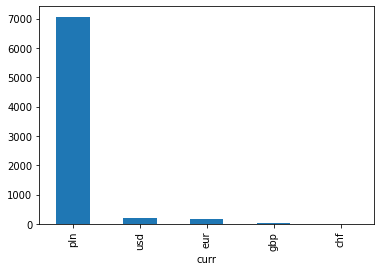

In [230]:
df.groupby("curr").count()["id"].sort_values(ascending=False).plot(kind="bar")
plt.show()

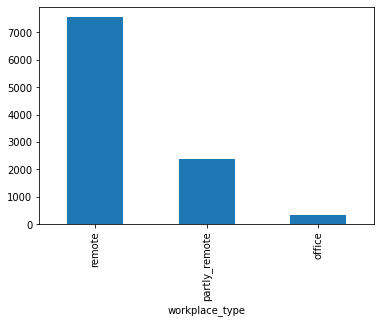

In [233]:
df.groupby("workplace_type").count()["id"].sort_values(ascending=False).plot(kind="bar")
plt.show()

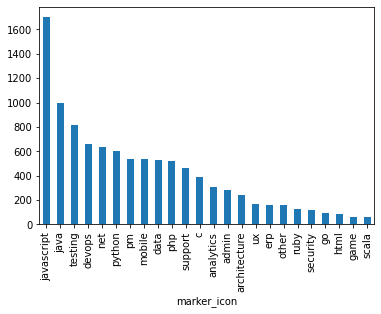

In [234]:
df.groupby("marker_icon").count()["id"].sort_values(ascending=False).plot(kind="bar")
plt.show()

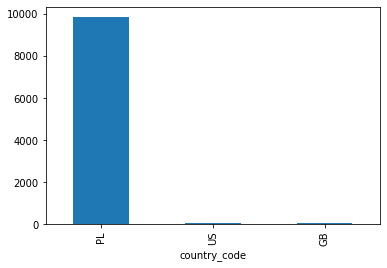

In [244]:
df.groupby("country_code").count()["id"].sort_values(ascending=False).head(3).plot(kind="bar")
plt.show()

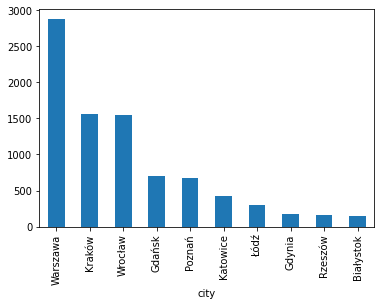

In [262]:
df.groupby("city").count()["id"].sort_values(ascending=False).head(10).plot(kind="bar")
plt.show()

 
 

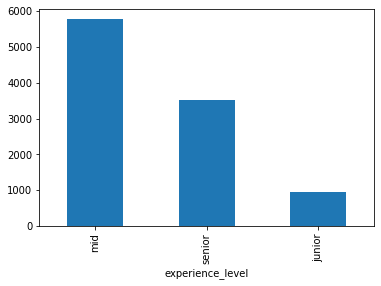

In [265]:
df.groupby("experience_level").count()["id"].sort_values(ascending=False).plot(kind="bar")
plt.show()


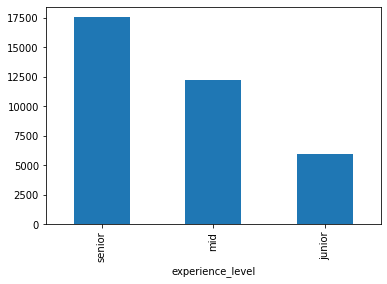

In [267]:
df.groupby("experience_level").mean()["salary_from"].sort_values(ascending=False).plot(kind="bar")
plt.show()

In [271]:
df.to_csv("data.csv")